In [1]:
%run prepareStats.py

Last GP in the database: the 2022 Brazilian Grand Prix


In [2]:
totalLaps = pd.Series(results.groupby(["raceId"])["laps"].max(), name="totalLaps")
results = results.merge(totalLaps, on = ["raceId"], how = "right")

In [3]:
crashDNF = results[(results.status.isin(crashes))]

In [4]:
crashDNF["progress"] =  crashDNF["laps"] / crashDNF["totalLaps"]

C:\Users\micha\AppData\Local\Temp\ipykernel_3016\1527855837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashDNF["progress"] =  crashDNF["laps"] / crashDNF["totalLaps"]


## Outlying races

In [5]:
crashDNF.groupby(["date", "location"]).size().nlargest(5)

date        location   
1975-07-19  Silverstone    16
1982-04-04  California     13
1984-07-08  Dallas         13
1989-11-05  Adelaide       13
1996-05-19  Monte-Carlo    13
dtype: int64

In [6]:
crashDNF[crashDNF["year"] > 2000].groupby(["date", "location"]).size().nlargest(5)

date        location    
2006-07-02  Indianapolis    10
2002-03-03  Melbourne        9
2003-04-06  São Paulo        8
2008-03-16  Melbourne        8
2002-05-26  Monte-Carlo      7
dtype: int64

In [7]:
crashDNF[crashDNF["year"] > 2009].groupby(["date", "location"]).size().nlargest(5)

date        location      
2010-10-24  Yeongam County    7
2012-09-02  Spa               6
2012-11-25  São Paulo         6
2017-09-17  Marina Bay        6
2018-04-29  Baku              6
dtype: int64

In [8]:
crashDNF[crashDNF["progress"] < 0.03].groupby(["date", "location"]).size().nlargest(5)

date        location    
1950-05-21  Monte-Carlo     11
1973-07-14  Silverstone     10
1994-07-31  Hockenheim      10
1958-05-30  Indianapolis     8
2002-03-03  Melbourne        8
dtype: int64

In [9]:
crashDNF[crashDNF["progress"] > 0.96].groupby(["date", "location"]).size().nlargest(5)

date        location    
1975-07-19  Silverstone     7
1953-05-30  Indianapolis    3
1953-06-21  Spa             2
2009-04-05  Kuala Lumpur    2
2014-06-08  Montreal        2
dtype: int64

## Outlying drivers

In [10]:
crashers = crashDNF["name"].drop_duplicates().tolist()

In [11]:
winners = wins["name"].drop_duplicates().tolist()

In [12]:
results[~results.name.isin(crashers)].groupby("name")["entries"].max().nlargest(10)

name
Masten Gregory           46
Charles Pic              39
Bob Anderson             26
Ian Burgess              26
Oscar Larrauri           21
Alex Ribeiro             20
Will Stevens             19
Felice Bonetto           17
Louis Chiron             17
Pierre-Henri Raphanel    17
Name: entries, dtype: int64

Masten Gregory has entered 46 championship races and never dropped out of a single one due to a crash or a collision, which is ironic: 

"Gregory's early years of competition were marked by many crashes, often the result of pushing sub-par machinery past its ability. He flipped a thankfully rollbar-equipped Maserati at the Venezuelan Grand Prix in 1957, totalled two sports cars in 1958, and another two in 1959 (a Lister-Jaguar and a Tojeiro-Jaguar). In the latter of these incidents he broke his leg and shoulder, keeping him away from his Formula 1 commitments." ([Wikipedia](https://en.wikipedia.org/wiki/Masten_Gregory))

In [13]:
wins[(~wins.name.isin(crashers))].groupby("name")["raceId"].nunique().nlargest(5)

name
Bob Sweikert           1
Jimmy Bryan            1
Johnnie Parsons        1
Lee Wallard            1
Ludovico Scarfiotti    1
Name: raceId, dtype: int64

Every single driver who has won more than 1 race has also dropped out of at least one race due to a crash or a collision.

In [14]:
results[(~results.name.isin(crashers))].groupby("name")["date"].max().nlargest(5)

name
Nyck de Vries       2022-09-11
Pietro Fittipaldi   2020-12-13
Jack Aitken         2020-12-06
Roberto Merhi       2015-11-29
Will Stevens        2015-11-29
Name: date, dtype: datetime64[ns]

In [15]:
crashDNF.groupby("name").size().nlargest(10)

name
Andrea de Cesaris       37
Riccardo Patrese        36
David Coulthard         32
Rubens Barrichello      32
Giancarlo Fisichella    30
Jean Alesi              30
Johnny Herbert          30
Michael Schumacher      30
Ukyo Katayama           30
Jarno Trulli            29
dtype: int64

In [16]:
carnageExperts = results[(results.status.isin(crashes)) & (results.entries >= 10)].groupby(["surname", "forename"]).size() / results.groupby(["surname", "forename"]).size()
carnageExperts.nlargest(10)

surname    forename
Andretti   Michael     0.461538
Brise      Tony        0.400000
Inoue      Taki        0.333333
Tuero      Esteban     0.312500
Katayama   Ukyo        0.309278
Chiesa     Andrea      0.300000
Lavaggi    Giovanni    0.300000
Scheckter  Ian         0.300000
Blundell   Mark        0.285714
Pantano    Giorgio     0.285714
dtype: float64

Andrea de Cesaris has dropped out of 37 races due to a crash or a collision. It's more meaningful to compare crashes-to-starts ratio: Michael Andretti is the true king, fired from McLaren in a middle of a debut season for crashing way too often.

In [17]:
currentExperts = results[(results.status.isin(crashes)) & (results.name.isin(currentDrivers))].groupby(["surname", "forename"]).size() / results.groupby(["surname", "forename"]).size()
currentExperts.nlargest(5)

surname     forename
Latifi      Nicholas    0.133333
Leclerc     Charles     0.107843
Hülkenberg  Nico        0.097826
Zhou        Guanyu      0.095238
Tsunoda     Yuki        0.093023
dtype: float64

In [18]:
currentExperts.nsmallest(5)

surname    forename
Ricciardo  Daniel      0.030303
Bottas     Valtteri    0.035000
Hamilton   Lewis       0.045307
Ocon       Esteban     0.045455
Norris     Lando       0.049383
dtype: float64

## The most challenging circuits in the Lewis Hamilton era

In [19]:
pd.options.display.float_format = '{:.2%}'.format

In [20]:
resultsLHera = results[results["year"] > 2006]

circuitsLHEResults = resultsLHera.groupby(["location"]).size()

In [21]:
crashDNFLHera = crashDNF[crashDNF["year"] > 2006]

circuitsDNFLHera = crashDNFLHera.groupby(["location"]).size()

In [22]:
circuitsLHeraGPs = resultsLHera.groupby(["location"])["raceId"].nunique()

In [23]:
mergedCircuitStats = pd.concat([circuitsLHeraGPs, circuitsLHEResults, circuitsDNFLHera], axis=1, keys=["circuitsLHeraGPs", "circuitsLHEResults", "circuitsDNFLHera"])

In [24]:
mergedCircuitStats["ratio"] =  mergedCircuitStats["circuitsDNFLHera"] / mergedCircuitStats["circuitsLHEResults"]

In [25]:
mergedCircuitStats["ratio"].sort_values(ascending=False).head(5)

location
Mugello          30.00%
Indianapolis     18.18%
Jeddah           17.50%
Yeongam County   15.96%
Oyama            14.29%
Name: ratio, dtype: float64

In [26]:
frequentCircuitStats = mergedCircuitStats[mergedCircuitStats["circuitsLHeraGPs"] > 2]

In [27]:
frequentCircuitStats["ratio"].sort_values(ascending=False).nlargest(10)

location
Yeongam County   15.96%
Monte-Carlo      14.06%
Marina Bay       11.87%
Melbourne        11.67%
Montreal         10.36%
Silverstone      10.28%
Imola            10.00%
São Paulo         9.49%
Baku              9.02%
Spa               8.82%
Name: ratio, dtype: float64

## What's the most dangerous part of a race?

In [28]:
crashDNFLHera = crashDNF[crashDNF["year"] > 2006]

In [29]:
whatLap = crashDNFLHera[["progress"]]

array([[<AxesSubplot:title={'center':'progress'}>]], dtype=object)

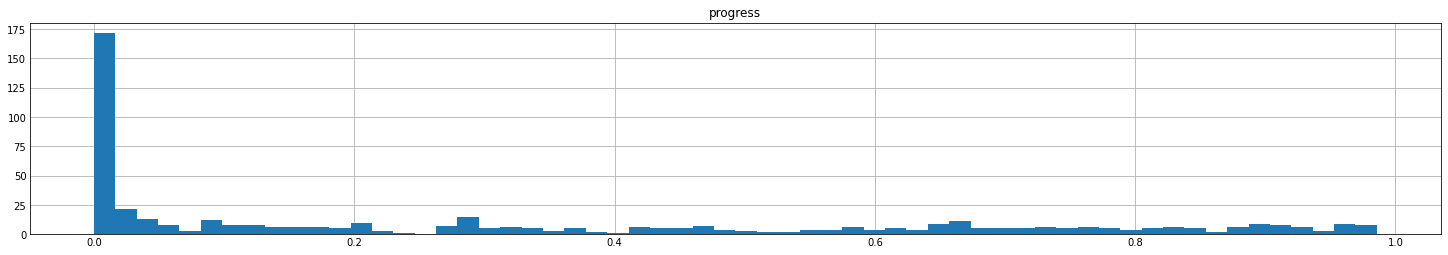

In [30]:
whatLap.hist(bins = 60)

In [31]:
crashDNFLHera[crashDNFLHera["laps"] == 0]["resultId"].count() / crashDNFLHera["resultId"].count()

0.30518234165067176

30 % of collisions take place in the first lap.

In [32]:
whatLap.median()

progress   17.24%
dtype: float64

50 % of collisions and crashes occur in the first 1/5 of laps.